In [1]:
# Import necessary libraries
import numpy as np  # Library for numerical operations
import pandas as pd  # Library for data analysis and data structures
import os  
import warnings  # To manage warning messages
import matplotlib.pyplot as plt  # Library for plotting
import seaborn as sns  # Advanced data visualization library
from sklearn.preprocessing import LabelEncoder  # To convert labels to numerical values
from sklearn.model_selection import train_test_split  # To split the dataset into training and testing sets
from sklearn.metrics import classification_report, confusion_matrix  # To compute classification report and confusion matrix

# TensorFlow and Keras modules
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # To augment image data
from tensorflow.keras.models import Sequential  # Keras model structure (sequential model)
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization, Conv2D, MaxPooling2D  # Neural network layers
from tensorflow.keras.optimizers import Adam  # Using Adam as the optimizer
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint  # Callbacks for early stopping and model checkpoint

# Hide warnings
warnings.filterwarnings("ignore")  # Hide warnings during execution


2024-11-16 11:22:13.300233: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-16 11:22:13.309789: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1731736333.322102    5595 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1731736333.325237    5595 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-16 11:22:13.336618: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:

directory ='Fish dataset'

In [3]:
# Data Loading Function
def load_data(directory):
    label = []
    path = []
    
    # Loop through the directory where the data is located
    for dir_name, _, filenames in os.walk(directory):
        for filename in filenames:
            # Load image files
            if dir_name.split()[-1] != 'GT' and filename.endswith('.jpg'):
                label.append(os.path.split(dir_name)[-1])  # Use the folder name as the label
                path.append(os.path.join(dir_name, filename))  # Add the file path
    
    # Create DataFrame
    data = pd.DataFrame({'path': path, 'label': label})
    return data

In [4]:
# Load the dataset
data = load_data(directory)

# Data inspection
print("Loaded data:")
print(data.head())
print("\nLabel distribution:")
print(data.label.value_counts())

# Missing value check
print("\nMissing value check:")
print(data.isnull().sum())

Loaded data:
                                                path               label
0  Fish dataset/Type 7 Indian Carp/Indian Carp505...  Type 7 Indian Carp
1  Fish dataset/Type 7 Indian Carp/Indian Carp305...  Type 7 Indian Carp
2  Fish dataset/Type 7 Indian Carp/Indian Carp705...  Type 7 Indian Carp
3  Fish dataset/Type 7 Indian Carp/Indian Carp376...  Type 7 Indian Carp
4  Fish dataset/Type 7 Indian Carp/Indian Carp054...  Type 7 Indian Carp

Label distribution:
label
Type 1 Pomfret          1579
Type 8 Black Pomfret    1471
Type 2 Mackerel         1356
Type 3 Black Snapper    1328
Type 5 Prawn            1136
Type 7 Indian Carp       974
Type 4 Indian Carp       752
Type 6 Pink Perch        519
Name: count, dtype: int64

Missing value check:
path     0
label    0
dtype: int64


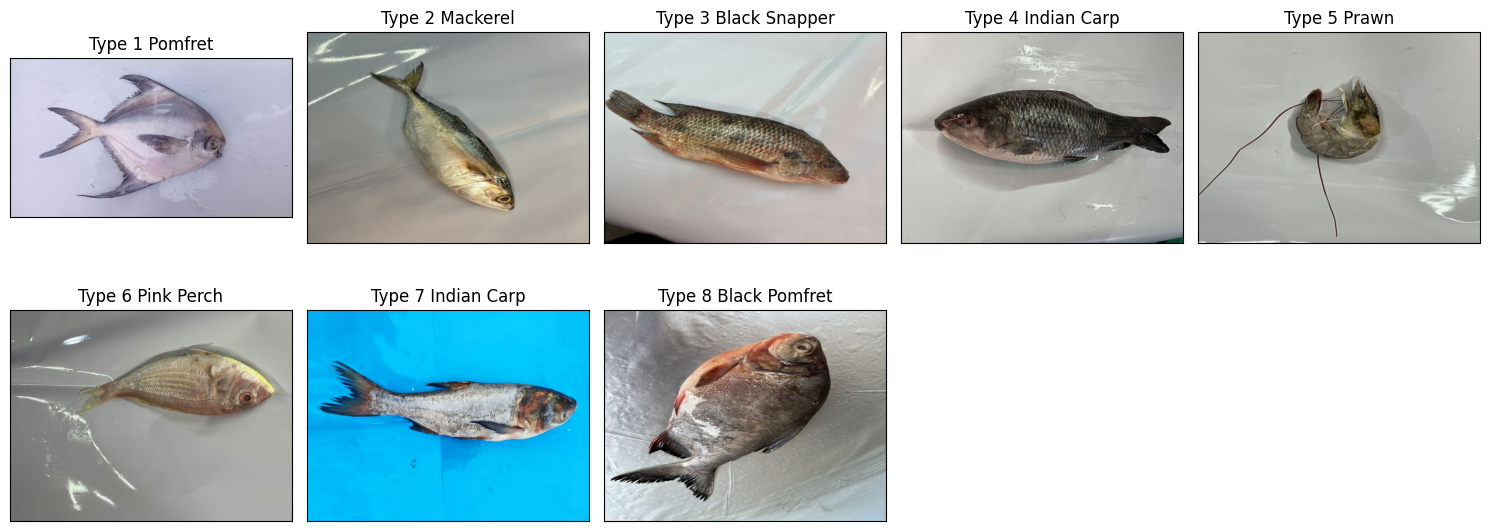

In [5]:
# Visualization Function
def visualize_samples(data):
    unique_data = data.groupby('label').first().reset_index()  # Get unique images by selecting the first image for each label
    num_images = len(unique_data)
    ncols = 5  # Number of images per row
    nrows = (num_images // ncols) + (num_images % ncols > 0)
    
    # Set up the image layout
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, nrows * 3),
                             subplot_kw={'xticks': [], 'yticks': []})

    axes = axes.flatten() if nrows > 1 else [axes]
    
    # Add each unique image to the visual area
    for i, ax in enumerate(axes[:num_images]):
        ax.imshow(plt.imread(unique_data['path'][i]))
        ax.set_title(unique_data['label'][i])
    
    # Remove axes if there are more axes than images
    for ax in axes[num_images:]:
        ax.remove()

    plt.tight_layout()
    plt.show()

# Call the visualization function
visualize_samples(data)  # Visualize the images and labels in the 'data' variable

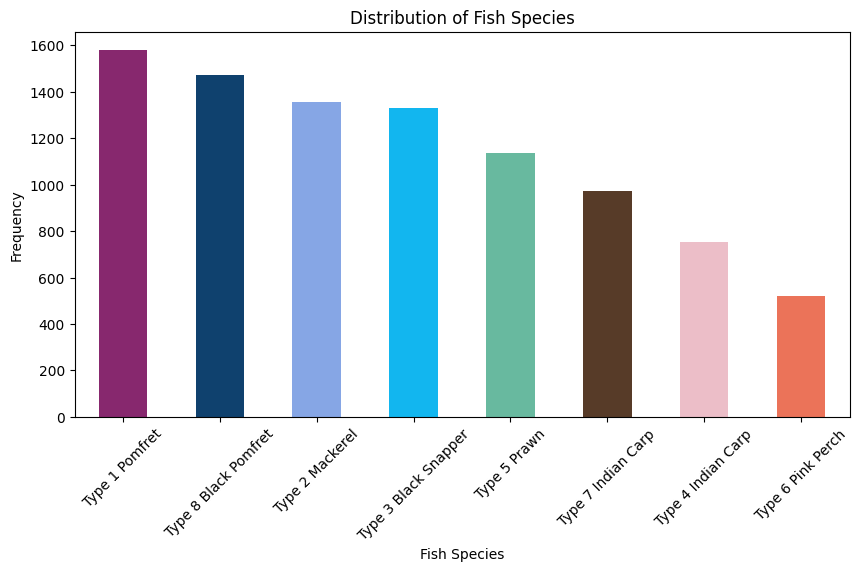

In [6]:
# Show class distribution with a bar chart
colors = np.random.rand(data['label'].value_counts().size, 3)

plt.figure(figsize=(10, 5))  # Figure size
data['label'].value_counts().plot(kind='bar', color=colors)
plt.title('Distribution of Fish Species')  # Title
plt.xlabel('Fish Species')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

In [7]:
# Convert labels to numerical values
label_encoder = LabelEncoder()
data['label'] = label_encoder.fit_transform(data['label'])  # Convert categorical labels to numerical values
data['label'] = data['label'].astype(str)  # Convert labels back to string

# Split the dataset
train_df, test_df = train_test_split(data, train_size=0.8, shuffle=True, random_state=1)  # Split the dataset into 80% training and 20% testing
print(f"Training dataset size: {len(train_df)}")
print(f"Test dataset size: {len(test_df)}")

Training dataset size: 7292
Test dataset size: 1823


In [8]:
# Data augmentation and normalization
train_datagen = ImageDataGenerator(
    rescale=1./255,              # Normalization: Converts pixel values from the range 0-255 to 0-1.
    rotation_range=40,           # Random rotation: Rotates images randomly between 0-40 degrees.
    width_shift_range=0.2,       # Horizontal shift: Shifts images horizontally by 20%.
    height_shift_range=0.2,      # Vertical shift: Shifts images vertically by 20%.
    shear_range=0.2,             # Shear: Applies random shearing transformations.
    zoom_range=0.2,              # Zoom: Zooms images by 20%.
    horizontal_flip=True,        # Horizontal flip: Flips images horizontally (left to right).
    fill_mode='nearest',         # Fill mode: Uses the nearest pixel value to fill empty areas.
    validation_split=0.2         # Validation split: Reserves 20% of the data for validation.
)

# Only normalization for the test dataset
test_datagen = ImageDataGenerator(rescale=1./255)  # Only normalization is applied to test data.

In [9]:
# Create training dataset
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='path',
    y_col='label',
    target_size=(224, 224),  # Image size (224x224 pixels)
    batch_size=32,           # Number of images to be processed at a time (32 images).
    class_mode='sparse',     # Set class mode to numerical value
    subset='training',       # Training subset
    shuffle=True             # Shuffle
)

# Create validation dataset
validation_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='path',
    y_col='label',
    target_size=(224, 224),  # Target size
    batch_size=32,
    class_mode='sparse',     # Set class mode to numerical value
    subset='validation',     # Validation subset
    shuffle=True             # Shuffle
)

# Create test dataset
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='path',
    y_col='label',
    target_size=(224, 224),  # Target size
    batch_size=32,
    class_mode='sparse',     # Set class mode to numerical value
    shuffle=False            # No shuffle (usually not used in test set)
)

Found 5834 validated image filenames belonging to 8 classes.
Found 1458 validated image filenames belonging to 8 classes.
Found 1823 validated image filenames belonging to 8 classes.


In [10]:
# Model creation
model = Sequential()

# Convolutional layers
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))  # First convolutional layer
model.add(MaxPooling2D(pool_size=(2, 2)))  # First pooling layer

model.add(Conv2D(64, (3, 3), activation='relu'))  # Second convolutional layer
model.add(MaxPooling2D(pool_size=(2, 2)))  # Second pooling layer

model.add(Conv2D(128, (3, 3), activation='relu'))  # Third convolutional layer
model.add(MaxPooling2D(pool_size=(2, 2)))  # Third pooling layer

model.add(Conv2D(256, (3, 3), activation='relu'))  # Fourth convolutional layer
model.add(MaxPooling2D(pool_size=(2, 2)))  # Fourth pooling layer

# Flattening and fully connected layers
model.add(Flatten())  # Flattening
model.add(Dense(512, activation='relu'))  # Fully connected layer
model.add(Dropout(0.5))  # Dropout to prevent overfitting
model.add(BatchNormalization())  # Batch normalization
model.add(Dense(len(label_encoder.classes_), activation='softmax'))  # Output layer

I0000 00:00:1731736335.943940    5595 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2612 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5


In [11]:
# Model compilation
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [12]:
# Early stopping and model checkpoint callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True)

In [13]:

history = model.fit(    
    train_generator,
    validation_data=validation_generator,
    epochs=15,
    callbacks=[early_stopping, model_checkpoint],
    verbose=1  # Show details of the training process
)

Epoch 1/15


I0000 00:00:1731736338.870519    8310 service.cc:148] XLA service 0x7cd0040112a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731736338.870911    8310 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce GTX 1650, Compute Capability 7.5
2024-11-16 11:22:18.926054: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1731736339.126254    8310 cuda_dnn.cc:529] Loaded cuDNN version 90300
2024-11-16 11:22:19.891630: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[32,32,222,222]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,3,224,224]{3,2,1,0}, f32[32,3,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"act

  2/183 ━━━━━━━━━━━━━━━━━━━━ 15s 83ms/step - accuracy: 0.1172 - loss: 2.2029

I0000 00:00:1731736345.777607    8310 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


 47/183 ━━━━━━━━━━━━━━━━━━━━ 35s 263ms/step - accuracy: 0.2776 - loss: 1.8773

2024-11-16 11:22:38.301478: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[10,32,222,222]{3,2,1,0}, u8[0]{0}) custom-call(f32[10,3,224,224]{3,2,1,0}, f32[32,3,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2024-11-16 11:22:38.548869: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[10,64,109,109]{3,2,1,0}, u8[0]{0}) custom-call(f32[10,32,111,111]{3,2,1,0}, f32[64,32,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend

183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step - accuracy: 0.3985 - loss: 1.5431

2024-11-16 11:23:18.476744: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[32,32,222,222]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,3,224,224]{3,2,1,0}, f32[32,3,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kRelu","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2024-11-16 11:23:18.588512: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[32,64,109,109]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,32,111,111]{3,2,1,0}, f32[64,32,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend

183/183 ━━━━━━━━━━━━━━━━━━━━ 77s 375ms/step - accuracy: 0.3991 - loss: 1.5415 - val_accuracy: 0.7435 - val_loss: 0.7747
Epoch 2/15
183/183 ━━━━━━━━━━━━━━━━━━━━ 58s 316ms/step - accuracy: 0.6921 - loss: 0.7864 - val_accuracy: 0.7956 - val_loss: 0.5888
Epoch 3/15
183/183 ━━━━━━━━━━━━━━━━━━━━ 56s 305ms/step - accuracy: 0.8291 - loss: 0.4525 - val_accuracy: 0.8813 - val_loss: 0.3505
Epoch 4/15
183/183 ━━━━━━━━━━━━━━━━━━━━ 56s 308ms/step - accuracy: 0.8982 - loss: 0.2939 - val_accuracy: 0.9040 - val_loss: 0.2620
Epoch 5/15
183/183 ━━━━━━━━━━━━━━━━━━━━ 56s 305ms/step - accuracy: 0.8269 - loss: 0.4728 - val_accuracy: 0.6262 - val_loss: 1.2594
Epoch 6/15
183/183 ━━━━━━━━━━━━━━━━━━━━ 56s 305ms/step - accuracy: 0.8343 - loss: 0.4590 - val_accuracy: 0.8601 - val_loss: 0.3996
Epoch 7/15
183/183 ━━━━━━━━━━━━━━━━━━━━ 56s 305ms/step - accuracy: 0.9124 - loss: 0.2490 - val_accuracy: 0.5706 - val_loss: 1.3317
Epoch 8/15
183/183 ━━━━━━━━━━━━━━━━━━━━ 56s 306ms/step - accuracy: 0.8032 - loss: 0.5337 - val

In [14]:
model.evaluate(test_generator)  # Evaluate the model on the test dataset

56/57 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.7599 - loss: 0.7102

2024-11-16 11:31:12.934154: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[31,32,222,222]{3,2,1,0}, u8[0]{0}) custom-call(f32[31,3,224,224]{3,2,1,0}, f32[32,3,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kRelu","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2024-11-16 11:31:13.082323: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[31,64,109,109]{3,2,1,0}, u8[0]{0}) custom-call(f32[31,32,111,111]{3,2,1,0}, f32[64,32,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend

57/57 ━━━━━━━━━━━━━━━━━━━━ 9s 158ms/step - accuracy: 0.7601 - loss: 0.7106


[0.7222913503646851, 0.7657707333564758]

In [15]:
model.save('fish.h5') 

In [16]:
from tensorflow.keras.models import load_model
import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# Load the model
model = load_model('fish.h5')
x=0
# Function to load and predict images
def predict_image(img_path, model, label_encoder):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Normalization

    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction, axis=1)
    print(predicted_class)
    x=predicted_class[0]
    class_name = label_encoder.inverse_transform(predicted_class)
    return class_name[0]

# Predict sample images
sample_images = ['Fish dataset/Type 1 Pomfret/Pomfret003.jpg',
                 'Fish dataset/Type 2 Mackerel/Mackerel112.jpg',
                 'Fish dataset/Type 3 Black Snapper/Black Snapper004.jpg',
                 'Fish dataset/Type 4 Indian Carp/Indian Carp002.jpg',
                 'Fish dataset/Type 5 Prawn/Prawn112.jpg',
                 'Fish dataset/Type 6 Pink Perch/Pink Perch005.jpg',
                 'Fish dataset/Type 7 Indian Carp/Indian Carp005.jpg',
                 'Fish dataset/Type 8 Black Pomfret/Black Pomfret004.jpg'
                 ]
class_names = ['Pomfret', 'Mackerel', 'Black Snapper', 'Indian Carp', 'Prawn', 'Pink Perch', 'Indian Carp', 'Black Pomfret']
for img_path in sample_images:
    class_name = predict_image(img_path, model, label_encoder)
    print(f"Image: {img_path} - Predicted Class: {class_name}")

2024-11-16 11:31:15.953786: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[1,256,24,24]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,128,26,26]{3,2,1,0}, f32[256,128,3,3]{3,2,1,0}, f32[256]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kRelu","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 771ms/step
[0]
Image: Fish dataset/Type 1 Pomfret/Pomfret003.jpg - Predicted Class: Type 1 Pomfret
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
[1]
Image: Fish dataset/Type 2 Mackerel/Mackerel112.jpg - Predicted Class: Type 2 Mackerel
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
[2]
Image: Fish dataset/Type 3 Black Snapper/Black Snapper004.jpg - Predicted Class: Type 3 Black Snapper
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
[3]
Image: Fish dataset/Type 4 Indian Carp/Indian Carp002.jpg - Predicted Class: Type 4 Indian Carp
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
[4]
Image: Fish dataset/Type 5 Prawn/Prawn112.jpg - Predicted Class: Type 5 Prawn
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
[5]
Image: Fish dataset/Type 6 Pink Perch/Pink Perch005.jpg - Predicted Class: Type 6 Pink Perch
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
[7]
Image: Fish dataset/Type 7 Indian Carp/Indian Carp005.jpg - Predicted Class: Type 8 Black Pomfret
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
[7]
Image: Fish dataset/Type 